# Integral ANOVA
Conny Lin | May 9, 2020

---

ANOVA and Tukey posthoc comparison of integral (area under the curve) between Hab curves of reversal freq, duration, and speed between 0mM and 400mM groups with the following outputs:
* Swarm plot
* ANOVA table in csv
* Tukey comparison in csv and heatmap 

**Notes**
* went to matlab and exported raw files from "habcurve_10sISI_201606151509" folder into csv

* See [here](https://stackoverflow.com/questions/13320262/calculating-the-area-under-a-curve-given-a-set-of-coordinates-without-knowing-t) as example. Two ways to do it, Trapezoidal rule vs Simpson's rule. Simpson's rule seems more accurate [see here](https://www.quora.com/State-why-Simpson-1-3-Rule-yields-more-accurate-estimates-than-the-Trapezoidal-Rule). [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html) has several rules in there

* See [here](https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/pandas) for regression fitting
* https://statisticsbyjim.com/regression/comparing-regression-lines/


---

## Library and functions

In [18]:
# import library
import os
import numpy as np
import pandas as pd
import scipy.integrate as integrate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [63]:
# functions
def report_stats_apa(stattype,dfreedom,testresult,pvalue,plimit=0.001,alpha=0.05):
    if pvalue<plimit:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p < {plimit}')
    elif pvalue>alpha:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p = n.s.')
    else:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p = {pvalue:.3f}')
    return stat_report_str

In [20]:
def convert_statsmodel_table2dataframe(statsmodel_object):
    column_names = statsmodel_object.data[0]
    d = statsmodel_object.data[1:]
    statsmodel_object_dataframe = pd.DataFrame(d,columns=column_names)
    return statsmodel_object_dataframe

## set local variables


In [21]:
# define path to folder
proj_dir = '/Users/connylin/Dropbox/CA/CA Publications/Manuscript RL Alcohol hab model slo1/3-Results/Fig2-wt 400mM/Data/Fig2-8A/habcurve_10sISI_20200509'

In [22]:
# define save suffix for this project
proj_suffix= 'integral_diff'

In [64]:
# define measures, statistical setting
measures = ['RevFreq','RevSpeed','RevDur']
pvlimit = 0.001
alpha = 0.05

## get data

In [24]:
# get data
fname = 'rawdata.csv'
df_data = pd.read_csv(os.path.join(proj_dir,fname)) 
# df_data.set_index(['mwtid'], inplace=True)
df_data

,mwtid,tap,time,Ntrack,RevFreq,RevSpeed,RevDur
0,1,1,99.975,39,0.968750,0.254244,2.71
1,1,2,109.957,34,0.781250,0.224336,2.26
2,1,3,119.975,35,0.781250,0.239216,2.04
3,1,4,129.976,42,0.743590,0.236765,2.04
4,1,5,139.935,49,0.608696,0.228649,1.85
...,...,...,...,...,...,...,...
13045,437,26,349.986,47,0.302326,0.216418,1.34
13046,437,27,359.983,36,0.117647,0.209353,1.39
13047,437,28,369.910,38,0.324324,0.175862,1.16
13048,437,29,379.992,39,0.243243,0.197710,1.31


In [25]:
# get database
fname = 'mwtdb.csv'
df_db = pd.read_csv(os.path.join(proj_dir,fname)) 
# df_db.set_index(['mwtid'], inplace=True)
# fill in NaN with 0mM
df_db.loc[df_db['rx'].isna(),'rx'] = ['0mM']
df_db

,mwtid,mwtname,mwtpath,expname,exp_date,tracker,expter,groupname,strain,rx,rc,preplate,ISI,postrec,tapN
0,1,20120310_165820,/Volumes/COBOLT/MWT/20120310C_BM_100s30x10s10s...,20120310C_BM_100s30x10s10s,20120310,C,BM,N2,N2,0mM,100s30x10s10s,100,10,10,30
1,2,20120310_171647,/Volumes/COBOLT/MWT/20120310C_BM_100s30x10s10s...,20120310C_BM_100s30x10s10s,20120310,C,BM,N2,N2,0mM,100s30x10s10s,100,10,10,30
2,3,20120310_173331,/Volumes/COBOLT/MWT/20120310C_BM_100s30x10s10s...,20120310C_BM_100s30x10s10s,20120310,C,BM,N2,N2,0mM,100s30x10s10s,100,10,10,30
3,4,20120310_172515,/Volumes/COBOLT/MWT/20120310C_BM_100s30x10s10s...,20120310C_BM_100s30x10s10s,20120310,C,BM,N2_400mM,N2,400mM,100s30x10s10s,100,10,10,30
4,5,20120310_174137,/Volumes/COBOLT/MWT/20120310C_BM_100s30x10s10s...,20120310C_BM_100s30x10s10s,20120310,C,BM,N2_400mM,N2,400mM,100s30x10s10s,100,10,10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,20151008_180035,/Volumes/COBOLT/MWT/20151008C_CL_100s30x10s10s...,20151008C_CL_100s30x10s10s_slo1rescue5,20151008,C,CL,N2,N2,0mM,100s30x10s10s,100,10,10,30
433,434,20151008_191108,/Volumes/COBOLT/MWT/20151008C_CL_100s30x10s10s...,20151008C_CL_100s30x10s10s_slo1rescue5,20151008,C,CL,N2,N2,0mM,100s30x10s10s,100,10,10,30
434,435,20151008_155436,/Volumes/COBOLT/MWT/20151008C_CL_100s30x10s10s...,20151008C_CL_100s30x10s10s_slo1rescue5,20151008,C,CL,N2_400mM,N2,400mM,100s30x10s10s,100,10,10,30
435,436,20151008_170351,/Volumes/COBOLT/MWT/20151008C_CL_100s30x10s10s...,20151008C_CL_100s30x10s10s_slo1rescue5,20151008,C,CL,N2_400mM,N2,400mM,100s30x10s10s,100,10,10,30


In [26]:
# merge database
df_merge = df_data.merge(df_db[['mwtid','strain','rx']],left_on='mwtid', right_on='mwtid', how='left')
df_merge

,mwtid,tap,time,Ntrack,RevFreq,RevSpeed,RevDur,strain,rx
0,1,1,99.975,39,0.968750,0.254244,2.71,N2,0mM
1,1,2,109.957,34,0.781250,0.224336,2.26,N2,0mM
2,1,3,119.975,35,0.781250,0.239216,2.04,N2,0mM
3,1,4,129.976,42,0.743590,0.236765,2.04,N2,0mM
4,1,5,139.935,49,0.608696,0.228649,1.85,N2,0mM
...,...,...,...,...,...,...,...,...,...
13045,437,26,349.986,47,0.302326,0.216418,1.34,N2,400mM
13046,437,27,359.983,36,0.117647,0.209353,1.39,N2,400mM
13047,437,28,369.910,38,0.324324,0.175862,1.16,N2,400mM
13048,437,29,379.992,39,0.243243,0.197710,1.31,N2,400mM


## get integral

In [29]:
# define groups (0mM vs 400mM) 
rxs = df_merge['rx'].unique().tolist()

In [30]:
# create output array
df_output = pd.DataFrame(df_db[['mwtid','rx','strain','groupname']])
for msr in measures:
    df_output[msr] = 'NaN'
#set index
df_output.set_index('mwtid', inplace=True)

In [31]:
# transform each plate's data in rows, columns = tpas
for msr in measures: # for each measure
    # transform data
    df_pivot = df_merge.pivot(index='mwtid',columns='tap',values=msr)
    for i in df_pivot.index: # go through each plate
        d = df_pivot.loc[i,:]
        df_output.loc[i,msr] = integrate.simps(d)
df_output

,rx,strain,groupname,RevFreq,RevSpeed,RevDur
mwtid,,,,,,
1,0mM,N2,N2,15.9418,5.94693,43.9192
2,0mM,N2,N2,14.7355,5.22972,39.6525
3,0mM,N2,N2,14.6671,7.32835,43.9133
4,400mM,N2,N2_400mM,7.27765,7.62934,40.7492
5,400mM,N2,N2_400mM,7.74099,8.50991,41.2333
...,...,...,...,...,...,...
433,0mM,N2,N2,18.4971,6.03137,45.7633
434,0mM,N2,N2,18.3727,6.48925,44.3833
435,400mM,N2,N2_400mM,5.94723,4.82872,56.2417


In [33]:
# remove missing values
# there are some nan values. probably don't have all the data, check which ones
print(f'database has {df_db.shape[0]} plates')
print(f'result has {df_pivot.shape[0]} plates')
print('remove missing plates')
# 228/235 mwtid needs to be dropped


# remove missing values (not sure why dropna() doesn't work)
bol_output = (df_output == 'NaN')
ind_to_drop = df_output.index[bol_output.any(axis=1)]
df_output.drop(index=ind_to_drop,inplace=True)
print(f'len of output {len(df_output)}') # not sure why using dropna() didn't drop

database has 437 plates
result has 435 plates
remove missing plates
len of output 435


In [34]:
# ensure data are in the right datatype
for msr in measures: # for each measure
    df_output[msr] = df_output[msr].astype('float64').copy()
df_output.dtypes

rx            object
strain        object
groupname     object
RevFreq      float64
RevSpeed     float64
RevDur       float64
dtype: object

## swarm plot

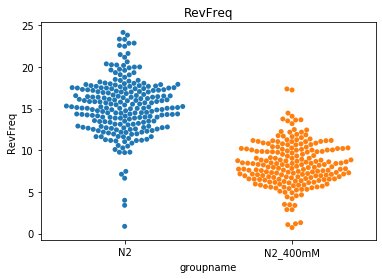

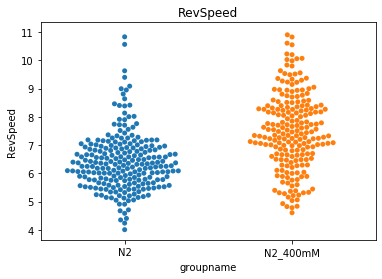

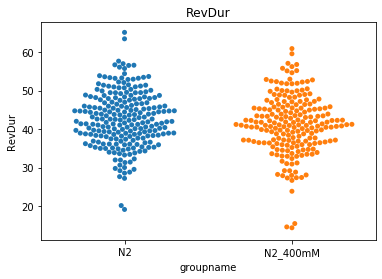

In [41]:
#visualize
for msr in measures: # for each measure
    # make graph
    plt.figure()
    sns.swarmplot(x='groupname',y=msr,data=df_output)
    plt.title(msr)

    # save fig 
    # create save file name
    savefname = f'{msr}_swarmplot_{proj_suffix}.jpeg'
    # construct save path
    savepath = os.path.join(proj_dir,savefname)
    # save fig
    plt.savefig(savepath)
    
    # close fig to save memory and avoid mistakenly calling the same fig
    plt.show() # this has to go after
    plt.close() 
    

## Excel graphing output

In [79]:
# create excel graphing output
iv = 'rx'
# save to excel
savefname = f'Desc Stats_{proj_suffix}.xlsx'
savepath = os.path.join(proj_dir,savefname)

with pd.ExcelWriter(savepath) as writer:
    for msr in measures:
        # get data
        df = df_output[['rx',msr]].copy()

        # create summary
        t = df.groupby(iv).agg(['count','mean','sem'])
        
        # save to excel
        t.to_excel(writer, sheet_name=msr)
    print('done')

done


## ANOVA

In [67]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import multicomp

# get anova written report format
iv = 'rx'

# do anova#
# for msr in measures: # for each measur
for msr in measures:
    print(f'\n{msr} ----------------')
    # get data
    df = df_output[['rx',msr]].copy()

    # run anova 
    lm = ols(f'{msr} ~ rx', data=df).fit()
    anovaT = anova_lm(lm)
    display(anovaT)
    # save to dictionary
    ANOVA_results
    # report result in APA format
    anova_apa = report_stats_apa('F', 
                                 anovaT.loc[iv,'df'],
                                 anovaT.loc[iv,'F'], 
                                 anovaT.loc[iv,'PR(>F)'], 
                                 pvlimit, 
                                 alpha_setting)
    print(f'{msr}: {anova_apa}')
    # save name
    savefname = f'{msr}_anova_{proj_suffix}.csv'
    # export anova table
    print('save')
    anovaT.to_csv(os.path.join(proj_dir,savefname))
    
    # run posthoc (!!ISSUE: doesn't work, solve it later with more than one group))
#     tukey = multicomp.pairwise_tukeyhsd(df[msr], df[iv]).summary()
    # put in table
#     tukey_df = convert_statsmodel_table2dataframe(tukey)
#     tukey_df.to_csv(os.path.join(proj_dir,f'{msr}_tukey.csv'))



RevFreq ----------------


,df,sum_sq,mean_sq,F,PR(>F)
rx,1.0,5237.259080,5237.259080,561.595511,3.280604e-80
Residual,433.0,4038.018709,9.325678,NaN,NaN


F(1) = 561.596, p < 0.001
RevFreq: None
save

RevSpeed ----------------


,df,sum_sq,mean_sq,F,PR(>F)
rx,1.0,129.253118,129.253118,92.332402,6.054112e-20
Residual,433.0,606.142576,1.399867,NaN,NaN


F(1) = 92.332, p < 0.001
RevSpeed: None
save

RevDur ----------------


,df,sum_sq,mean_sq,F,PR(>F)
rx,1.0,217.728176,217.728176,3.997721,0.046186
Residual,433.0,23582.511522,54.463075,NaN,NaN


F(1) = 3.998, p = 0.046
RevDur: None
save
